In [1]:
import numpy as np
from collections import Counter
from itertools import repeat
import os
import subprocess
import h5py as h5

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
def get_windows(t_start, t_end, win_len, skip):
    '''
    Given a time interval [t_start, t_end], 
    compute lists of window start and end times.
    Windows start every 'skip' samples and are 'win_len' samples long
    -checked
    '''
    assert(skip > 0)
    win_starts = np.arange(t_start, t_end, skip)
    win_ends = win_starts + win_len -1
    return (win_starts, win_ends)

def spikes_in_interval(spikes, t_lo, t_hi, cell_group):
    ''' 
    Given an array of spikes, find all the spikes whose time is between t_lo and t_hi inclusive
    store them in the 
    '''
    if len(spikes) == 0:
        return
    
    m = int(np.floor((len(spikes)) / 2))
    
    if t_lo < spikes[m, 0]:
        spikes_in_interval(spikes[0:m], t_lo, t_hi, cell_group)
    if t_lo <= spikes[m, 0] and t_hi >= spikes[m,0]:
        cell_group.append(spikes[m, 1])  
    if t_hi > spikes[m, 0]:
        spikes_in_interval(spikes[m+1:], t_lo, t_hi, cell_group)
        
def total_firing_rates(spikes, stim_start, stim_end):
    
    stim_spikes = []
    spikes_in_interval(spikes, stim_start, stim_end, stim_spikes)
    c = Counter(stim_spikes)
    return c
    
def spike_list_to_cell_group(spike_list, clu_rates, thresh, dt, T):
    ''' 
    Given a spike list, first counts number of each spikes from each cluster
    then given a dictionary that maps clusters to total firing rates, computes whether the cluster's firing
    rate in the spike list exceeded some threshold by dividing the cluster's number of in-window spikes by the 
    window length in seconds and then checking if that value is greater than the threshold times the cluster total firing rate givne in clu_rates
    '''
    
    c = Counter(spike_list)
    cg = set()
    
    for clu in clu_rates.keys():
        if (c[clu] / dt) >= (thresh*clu_rates[clu] / T):
            cg.add(clu)
    return cg

def spikes_to_cell_groups(spikes, stim_start, stim_end, win_len, fs, thresh):
    
    total_frs = total_firing_rates(spikes, stim_start, stim_end)
    win_starts, win_ends = get_windows(stim_start, stim_end, win_len, win_len)
    cell_groups = []
    dt = win_len / fs
    T = (stim_end - stim_start) / fs
    for ind, (ws, we) in enumerate(zip(win_starts, win_ends)):
        spike_list = []
        spikes_in_interval(spikes, ws, we, spike_list)
        if spike_list:
            window_time = (we + ws) / 2 - stim_start
            cell_groups.append((ind, window_time, sorted(tuple(spike_list_to_cell_group(spike_list, total_frs, dt, thresh, T)))))
    return cell_groups

def cell_groups_to_bin_mat(cell_groups, clus, nwins):
    ncells = len(clus)
    bin_mat = np.zeros((ncells, nwins))
    for cg in cell_groups:
        cginds = np.isin(clus, cg[2])
        bin_mat[cginds, cg[0]] = 1
    return bin_mat

def build_perseus_persistent_input(cell_groups, savefile):
    """
    Formats cell group information as an input file
    for the Perseus persistent homology software, but assigns filtration
    levels for each cell group based on the time order of their appearance
    in the signal.

    Parameters
    ----------
    cell_groups : list
        cell_group information returned by spikes_to_cell_groups
    savefile : str
        File in which to put the formatted cellgroup information

    Returns
    ------
    savefile : text File
        input file for perseus
    """
    with open(savefile, "w+") as pfile:
        pfile.write("1\n")
        for cell_group in cell_groups:
            grp = list(map(int, list(cell_group[2])))
            grp_dim = len(grp) - 1
            if grp_dim < 0:
                continue
            vert_str = str(grp)
            vert_str = vert_str.replace("[", "")
            vert_str = vert_str.replace("]", "")
            vert_str = vert_str.replace(" ", "")
            vert_str = vert_str.replace(",", " ")
            out_str = str(grp_dim) + " " + vert_str + " {}\n".format(str(cell_group[0] + 1))
            pfile.write(out_str)
    return savefile

def run_perseus(pfile):
    """
    Runs Perseus persistent homology software on the data in pfile

    Parameters
    ------
    pfile : str
        File on which to compute homology

    Returns
    ------
    betti_file : str
        File containing resultant betti numbers

    """
    pfile_split = os.path.splitext(pfile)
    of_string = pfile_split[0]
    perseus_command = "perseus"
    perseus_return_code = subprocess.call(
        [perseus_command, "nmfsimtop", pfile, of_string]
    )

    betti_file = of_string + "_betti.txt"
    # betti_file = os.path.join(os.path.split(pfile)[0], betti_file)

    return betti_file

def read_perseus_result(betti_file):
    bettis = []
    f_time = []
    try:
        with open(betti_file, "r") as bf:
            for bf_line in bf:
                if len(bf_line) < 2:
                    continue
                betti_data = bf_line.split()
                filtration_time = int(betti_data[0])
                betti_numbers = list(map(int, betti_data[1:]))
                bettis.append([filtration_time, betti_numbers])
    except:
        bettis.append([-1, [-1]])
    return bettis

def compute_bettis(spikes, stim_start, stim_end, win_len, fs, thresh):
    
    win_starts, win_ends = get_windows(stim_start, stim_end, win_len, win_len)
    cell_groups = spikes_to_cell_groups(spikes, stim_start, stim_end, win_len, fs, thresh)
    build_perseus_persistent_input(cell_groups, './test.betti')
    betti_file = run_perseus('./test.betti')
    betti_nums = read_perseus_result(betti_file)
    betti_nums = [[win_starts[x[0]-1] - stim_start, x[0], x[1]] for x in betti_nums]
    
    return betti_nums
    
from scipy.interpolate import interp1d
def betti_curve_func(betti_nums, dim, stim_start, stim_end, fs, t_in_seconds=False):
    
    betti_ts = [x[0] for x in betti_nums]
    betti_vals = [x[2][dim] for x in betti_nums]
    if t_in_seconds:
        betti_ts = list(map(lambda x: x / fs, betti_ts))
    f = interp1d(betti_ts, betti_vals, kind='zero', bounds_error = False, fill_value=(0, betti_vals[-1]))
    return f

def kwik_get_trials(kwikfile):
    with h5.File(kwikfile, 'r') as f:
        stim_names = list(f['/event_types/Stimulus/text'])
        stim_names = [x.decode('utf-8') for x in stim_names]
        stim_start_times = list(f['/event_types/Stimulus/time_samples'])
        stim_end_times = list(f['/event_types/Stimulus/stimulus_end'])
    return list(zip(stim_names, stim_start_times, stim_end_times))
        
    
def kwik_get_spikes(kwikfile):
    with h5.File(kwikfile, 'r') as f:
        spikes_clus = np.array(f['/channel_groups/0/spikes/clusters/main'])
        spikes_times = np.array(f['/channel_groups/0/spikes/time_samples'])
        
    spikes = np.vstack((spikes_times, spikes_clus)).T
    return spikes

In [60]:
n_t = 1048563
fr = 100
n_sp = int(fr * (n_t / 30000))
ts = sorted(np.random.randint(n_t, size=n_sp))
s = np.random.randint(10, size=n_sp)
spikes = np.vstack((ts, s))
spikes =spikes.T
print(n_sp/n_t * 30000)
print(n_sp)

99.9939917773181
3495


In [61]:
# get total firing rates:

stim_start = 500
stim_end = 123000
fs = 30000
T = (stim_end - stim_start) / fs
win_len = 1239
dt = win_len / fs

In [8]:
%time cell_groups = spikes_to_cell_groups(spikes, stim_start, stim_end, win_len, fs)

CPU times: user 8.43 ms, sys: 42 µs, total: 8.48 ms
Wall time: 8.38 ms


In [34]:
nwin = len(win_starts)
ncells = 10
cell_groups_to_bin_mat(cell_groups, ncells, nwin)

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [38]:
build_perseus_persistent_input(cell_groups, './test.betti')

run_perseus('./test.betti')

read_perseus_result('./test_betti.txt')



'./test.betti'

In [11]:
%time betti_nums = compute_bettis(spikes, stim_start, stim_end, win_len, fs)
print(betti_nums)

CPU times: user 6.97 ms, sys: 3.9 ms, total: 10.9 ms
Wall time: 49.6 ms
[[1239, 1, [1, 0, 0, 0, 0]], [3717, 3, [1, 1, 0, 0, 0]], [4956, 4, [1, 0, 0, 0, 0]], [13629, 11, [1, 1, 0, 0, 0]], [21063, 17, [1, 1, 1, 0, 0]], [22302, 18, [1, 1, 2, 0, 0]], [27258, 22, [1, 0, 3, 0, 0]], [33453, 27, [1, 0, 4, 0, 0]], [38409, 31, [1, 0, 6, 0, 0]], [40887, 33, [1, 0, 8, 0, 0]], [50799, 41, [1, 0, 7, 0, 0]], [52038, 42, [1, 0, 8, 0, 0]], [58233, 47, [1, 0, 7, 0, 0]], [61950, 50, [1, 0, 7, 0, 0]], [68145, 55, [1, 0, 8, 0, 0]], [76818, 62, [1, 0, 7, 1, 0]], [85491, 69, [1, 0, 5, 1, 0]], [95403, 77, [1, 0, 6, 1, 0]], [100359, 81, [1, 0, 5, 1, 0]], [102837, 83, [1, 0, 4, 1, 0]], [106554, 86, [1, 0, 3, 1, 0]], [113988, 92, [1, 0, 3, 2, 0]]]


In [20]:
f = betti_curve_func(betti_nums, 2, stim_start, stim_end, fs, t_in_seconds=True)
    

In [30]:
trials = kwik_get_trials('/home/brad/experiments/B1146/sorted/block-4-AP-2300-ML-400-Z-1750/experiment1_101.kwik')

In [36]:
spikes = kwik_get_spikes('/home/brad/experiments/B1146/sorted/block-4-AP-2300-ML-400-Z-1750/experiment1_101.kwik')

In [39]:
spikes

array([[      165,        51],
       [      359,         9],
       [      570,        83],
       ...,
       [543635798,       159],
       [543636109,        32],
       [543636282,       146]])

In [11]:
kwikfile = '/home/brad/experiments/B1146/sorted/block-4-AP-2300-ML-400-Z-1750/experiment1_101.kwik'
spikes = kwik_get_spikes(kwikfile)
trials = kwik_get_trials(kwikfile)

In [40]:
from ephys import core, events
bp = '/home/brad/krista/B1083/P03S03/'
kwikfile = '/home/brad/krista/B1083/P03S03/B1083_cat_P03_S03_1.kwik'
trials = events.load_trials(bp)
spikes = core.load_spikes(bp)
clus = core.load_clusters(bp)
fs = core.load_fs(bp)

gc = list(clus[clus['quality']=='Good']['cluster'])
spikes = spikes[spikes['cluster'].isin(gc)]
spike_t = np.array(spikes['time_samples']).astype(int)
spike_clu = np.array(spikes['cluster']).astype(int)
spikes = np.vstack((spike_t, spike_clu)).T
spikes.shape

stim_name = list(trials['stimulus'])
stim_start = list(trials['time_samples'])
stim_end = list(trials['stimulus_end'])
trials = list(zip(stim_name, stim_start, stim_end))


In [41]:
import tqdm
trial_subset = trials
win_len = np.round(0.01 * fs)
t = np.linspace(-1, 7, 1000)

betti_curves = {}
for tr in tqdm.tqdm(trial_subset):
    stim_start = tr[1]
    stim_end = tr[2]
    stim_name = tr[0]
    betti_nums = compute_bettis(spikes, stim_start, stim_end, win_len, fs, thresh=4.0)
    betti_func = betti_curve_func(betti_nums, 2, stim_start, stim_end, fs, t_in_seconds=True)
    betti_curve = betti_func(t)
    
    if stim_name not in betti_curves.keys():
        betti_curves[stim_name] = [] 
    betti_curves[stim_name].append(betti_curve)


100%|██████████| 160/160 [00:31<00:00,  5.12it/s]


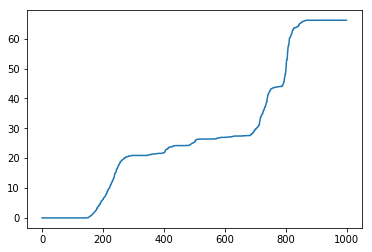

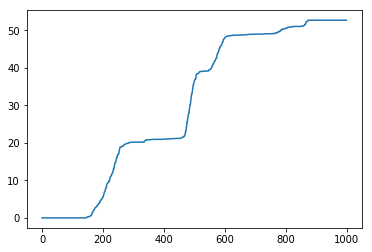

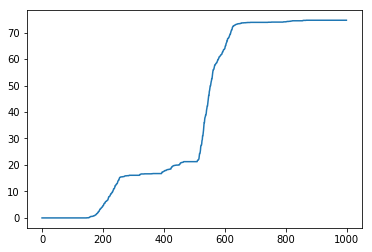

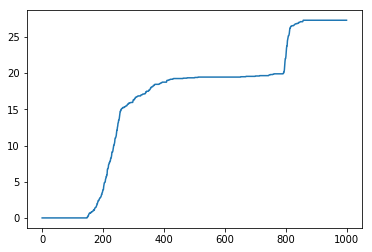

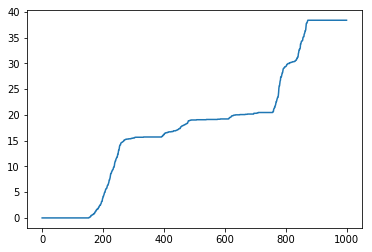

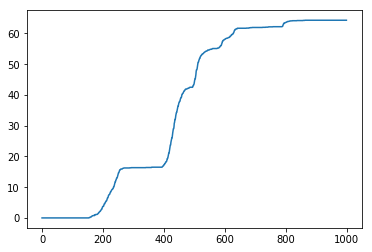

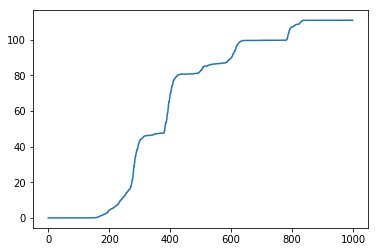

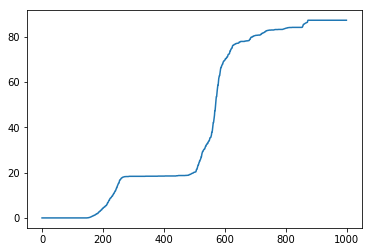

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

for stim in betti_curves.keys():
    c = np.vstack(betti_curves[stim])
    c = np.mean(c, axis=0)
    plt.figure()
    plt.plot(c)

In [95]:
betti_nums = compute_bettis(spikes, stim_start, stim_end, win_len, fs, thresh=4.0)

In [34]:
# test to see if we get same binmats
stim_start = trials[0][1]
stim_end = trials[0][2]
win_len = np.round(0.01*fs)
ncells = len(clus)
wins = get_windows(stim_start, stim_end, win_len, win_len)
nwins = len(wins[0])
print(stim_start, stim_end, fs, win_len, nwins, ncells)

80064 200064 20000.0 200.0 600 127


In [19]:
import tqdm
trial_subset = trials
win_len = np.round(0.01 * fs)
t = np.linspace(-1, 7, 1000)

binmats = {}
for tr in tqdm.tqdm(trial_subset):
    stim_name = tr[0]
    stim_start = tr[1]
    stim_end = tr[2]
    new_cgs = None
    new_binmat = None
    new_cgs = spikes_to_cell_groups(spikes, stim_start, stim_end, win_len, fs, thresh=1)
    new_binmat = cell_groups_to_bin_mat(new_cgs, gc, nwins)
    if stim_name not in binmats.keys():
        binmats[stim_name] = [] 
    binmats[stim_name].append(new_binmat)


100%|██████████| 160/160 [00:13<00:00, 11.50it/s]


In [15]:
# Loop through each bird in our list and bin the data
# Binning Parameters
import neuraltda.topology2 as tp2
import glob
windt = 10.0                      # milliseconds
dtovr = 0                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'TestNewAlgos'        # BootStrap Populations
bdfs = {}    
print(bp)
block_path = bp
bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print(bdf)


/home/brad/krista/B1083/P03S03/
/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-0_seg-0-0-TestNewAlgos/20190917T223802Z-10.0-0.binned


In [16]:
stim = 'M_40k'
with h5.File(bdf) as f:
    old_binmat = np.array(f[stim]["pop_tens"])

In [17]:
old_binmat[:, :, 0]

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 100.,   0., ...,   0.,   0.,   0.]])

In [20]:
binmats['M_40k'][0]*100

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 100.,   0., ...,   0.,   0.,   0.]])

In [21]:
n_old = np.nonzero(old_binmat[:, :, 0])

In [22]:
n_new = np.nonzero(binmats['M_40k'][0])

In [24]:
np.set_printoptions(threshold=np.inf)
print(n_old[0].shape)
print(n_new[0].shape)

(1045,)
(1045,)


In [165]:
test_trial = ('M_40k', 692964, 812964)


In [29]:
thresh = 4.0
gc = np.array(gc)
old_cgs = tp2.calc_cell_groups(old_binmat[:, :, 0], gc, thresh)

In [38]:
# test to see if we get same binmats
stim_start = 692964
stim_end = 812964

new_cgs = spikes_to_cell_groups(spikes, stim_start, stim_end, win_len, fs, thresh=1)

In [39]:
new_cgs

[(0, 99.5, [8, 72]),
 (1, 299.5, [79, 123, 133]),
 (2, 499.5, [13, 16]),
 (3, 699.5, [120]),
 (4, 899.5, [2, 18, 53, 121, 123, 133]),
 (5, 1099.5, [2, 11, 18, 28, 57]),
 (6, 1299.5, [54, 122]),
 (7, 1499.5, [19, 41, 121]),
 (8, 1699.5, [5, 17, 18, 27, 51, 73, 77]),
 (9, 1899.5, [18, 34, 82, 133]),
 (10, 2099.5, [19, 24, 46, 54, 73, 121, 122]),
 (11, 2299.5, [18, 50, 54]),
 (12, 2499.5, [18, 27, 52, 54, 77, 132]),
 (13, 2699.5, [14, 27, 54, 89]),
 (14, 2899.5, [28, 56, 73, 77, 88]),
 (15, 3099.5, [5, 18, 27, 38, 51, 53, 70]),
 (16, 3299.5, [18, 19, 28, 34, 50, 54, 70, 97, 133]),
 (17, 3499.5, [5, 16, 27, 39, 41, 88, 120]),
 (18, 3699.5, [11, 18, 27, 41, 54]),
 (19, 3899.5, [18, 27, 51, 53]),
 (20, 4099.5, [5, 18, 39, 57, 85, 122]),
 (21, 4299.5, [11, 19, 97]),
 (22, 4499.5, [51, 97, 122]),
 (23, 4699.5, [27, 34, 51, 73, 94]),
 (24, 4899.5, [27, 51, 54, 70, 121]),
 (25, 5099.5, [16, 28]),
 (26, 5299.5, [27, 70]),
 (27, 5499.5, [27, 51, 53, 88, 94, 120, 121]),
 (28, 5699.5, [2, 27, 52]),


In [33]:
old_cgs

[[0, array([ 8, 72])],
 [1, array([ 79, 123, 133])],
 [2, array([13, 16])],
 [3, array([120])],
 [4, array([  2,  18,  53, 121, 123, 133])],
 [5, array([ 2, 11, 18, 28, 57])],
 [6, array([ 54, 122])],
 [7, array([ 19,  41, 121])],
 [8, array([ 5, 17, 18, 27, 51, 73, 77])],
 [9, array([ 18,  34,  82, 133])],
 [10, array([ 19,  24,  46,  54,  73, 121, 122])],
 [11, array([18, 50, 54])],
 [12, array([ 18,  27,  52,  54,  77, 132])],
 [13, array([14, 27, 54, 89])],
 [14, array([28, 56, 73, 77, 88])],
 [15, array([ 5, 18, 27, 38, 51, 53, 70])],
 [16, array([ 18,  19,  28,  34,  50,  54,  70,  97, 133])],
 [17, array([  5,  16,  27,  39,  41,  88, 120])],
 [18, array([11, 18, 27, 41, 54])],
 [19, array([18, 27, 51, 53])],
 [20, array([  5,  18,  39,  57,  85, 122])],
 [21, array([11, 19, 97])],
 [22, array([ 51,  97, 122])],
 [23, array([27, 34, 51, 73, 94])],
 [24, array([ 27,  51,  54,  70, 121])],
 [25, array([16, 28])],
 [26, array([27, 70])],
 [27, array([ 27,  51,  53,  88,  94, 120, 1